# RAG Evaluation Without Ground Truth — Experiments

**Mục tiêu:** Thử nghiệm các framework evaluation không cần `expected_answer` và `ground_truth_context`

## Vấn đề

Hệ thống hiện tại phụ thuộc vào:
- ❌ `expected_answer` — không có sẵn trong thực tế
- ❌ `ground_truth_context` — không có vì RAG tự động retrieve

## Giải pháp

Test 3 frameworks:
1. **DeepEval** — LLM-as-Judge (no ground truth mode)
2. **RAGAS** — RAG-specific metrics
3. **OpenRAG-Eval** (Optional) — Research approach

## Workflow

1. Load test cases
2. Generate answers from RAG API
3. Evaluate with each framework
4. Meta-evaluate: So sánh consistency
5. Human-in-the-loop validation

---

## 📦 Setup & Installation

Cài đặt các thư viện cần thiết

In [1]:
# Install required packages (uncomment if needed)
# !pip install ragas datasets langchain langchain-community langchain-openai
# !pip install deepeval pandas matplotlib seaborn scipy

import sys
import os
import json
import pandas as pd
import numpy as np
from typing import Dict, List, Any
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append(os.path.abspath('.'))

print("✅ Setup complete!")

✅ Setup complete!


In [2]:
import json
import csv
file_path = "../data/rag_results.json"

# Đọc file JSON
with open(file_path, "r", encoding="utf-8-sig") as f:
    questions = json.load(f)
print(questions)


[{'question_id': 'Q001', 'question': 'Ngành Kỹ thuật Máy tính có thể làm những công việc gì sau khi tốt nghiệp?', 'answer': 'Dựa trên các tài liệu được cung cấp, sinh viên tốt nghiệp ngành Cử nhân Công nghệ Thông tin có thể làm việc trong nhiều phạm vi và lĩnh vực khác nhau, cụ thể như:\n\n| Công việc sau tốt nghiệp |\n|---|\n| Tham mưu, tư vấn |\n| Tổ chức thực hiện nhiệm vụ với tư cách của một chuyên viên trong lĩnh vực CNTT |\n| Nghiên cứu phát triển và ứng dụng công nghệ thông tin |\n\n**Nguồn tài liệu:**\n\n*   Cử Nhân Công Nghệ Thông Tin Nhật - 1.2\n*   Cử nhân Công Nghệ Thông Tin - 1\\. GIỚI THIỆU CHUNG - 1.1. Mục tiêu đào tạo\n*   Cử nhân Công Nghệ Thông Tin Văn Bằng Đại Học Thứ 2 - 1.1. Mục tiêu đào tạo\n*   Cử nhân Công Nghệ Thông Tin Liên Thông - 1.1. Mục tiêu đào tạo', 'contexts': [{'score': 13.901946, 'doc_id': 'd3f2c2f8-a16a-4d6b-a53c-d6157afce5d4', 'chunk_index': 13, 'content': 'Sinh viên tốt nghiệp Chương trình đào tạo Cử nhân chính quy ngành Công nghệ Thông tin Việt – 

## 3️⃣ RAGAS Evaluation (No Ground Truth)

RAGAS có các metrics không cần `expected_answer`:
- **Faithfulness** — Answer có faithful với retrieved context không?
- **Answer Relevancy** — Answer có relevant với question không?

Cả 2 metrics này đều reference-free!

In [ ]:
# =========================================
# RAGAS Evaluation: Faithfulness + AnswerRelevancy + ContextPrecisionWithReference
# =========================================

import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.metrics import Faithfulness, AnswerRelevancy, LLMContextPrecisionWithReference
from ragas import evaluate
from datasets import Dataset
import pandas as pd

# -------------------------
# 1️⃣ Setup API Key via environment variable
# -------------------------
api_key = os.getenv("OPENAI_API_KEY", "")
os.environ["OPENAI_API_KEY"] = api_key

# Use LangChain ChatOpenAI
ragas_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

# Setup embeddings
ragas_embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

# -------------------------
# 2️⃣ Chuẩn bị dataset với reference answers (nếu có)
# -------------------------
ragas_data = {
    'question_id': [q['question_id'] for q in questions],
    'question': [q['question'] for q in questions],
    'answer': [q['answer'] for q in questions],
    'contexts': [
        [c['content'] for c in q['contexts']]
        for q in questions
    ],
    'reference': [q.get('reference_answer', q['answer']) for q in questions]  # Use reference if available
}

ragas_dataset = Dataset.from_dict(ragas_data)

# -------------------------
# 3️⃣ Khởi tạo metrics (Faithfulness + AnswerRelevancy + ContextPrecisionWithReference)
# -------------------------
print("📝 Initializing metrics...")
faith_metric = Faithfulness(llm=ragas_llm)
rel_metric = AnswerRelevancy(llm=ragas_llm, embeddings=ragas_embeddings)
context_precision = LLMContextPrecisionWithReference(llm=ragas_llm)

# -------------------------
# 4️⃣ Chạy Faithfulness + AnswerRelevancy + ContextPrecisionWithReference evaluation
# -------------------------
print("🚀 Starting RAGAS evaluation...")
print("⏳ This may take a few minutes...\n")

ragas_results = evaluate(
    ragas_dataset,
    metrics=[faith_metric, rel_metric, context_precision],
    llm=ragas_llm,
    embeddings=ragas_embeddings
)

# -------------------------
# 5️⃣ Check available keys in results
# -------------------------
print("📋 Available metric keys in results:")
available_keys = list(ragas_results._scores_dict.keys())
print(available_keys)

# -------------------------
# 6️⃣ Xác định key name cho context precision
# -------------------------
context_precision_key = None
for key in available_keys:
    if 'context' in key.lower() and 'precision' in key.lower():
        context_precision_key = key
        break

print(f"\n📌 Context Precision key: {context_precision_key}")

# -------------------------
# 7️⃣ Kết hợp tất cả kết quả + tính total score
# -------------------------
result_dict = {
    'question_id': ragas_dataset['question_id'],
    'question': ragas_dataset['question'],
    'answer': ragas_dataset['answer'],
    'faithfulness': ragas_results['faithfulness'],
    'answer_relevancy': ragas_results['answer_relevancy'],
}

# Thêm context precision nếu có
if context_precision_key:
    result_dict['context_precision'] = ragas_results[context_precision_key]

# Tạo DataFrame
final_results_df = pd.DataFrame(result_dict)

# -------------------------
# 7️⃣1️⃣ Tính total_score (trọng số mặc định: faith 0.4, relevancy 0.35, context 0.25)
# -------------------------
weights = {'faithfulness': 0.4, 'answer_relevancy': 0.35, 'context_precision': 0.25}
final_results_df['total_score'] = (
    final_results_df['faithfulness'] * weights['faithfulness'] +
    final_results_df['answer_relevancy'] * weights['answer_relevancy'] +
    (final_results_df['context_precision'] * weights['context_precision'] if context_precision_key else 0)
)

# -------------------------
# 8️⃣ Xuất kết quả
# -------------------------
print("\n📊 Final Results:")
print(final_results_df)

final_results_df.to_csv("ragas_evaluation_results.csv", index=False)
print("\n✅ Results exported to ragas_evaluation_results.csv")

# -------------------------
# 9️⃣ Summary Statistics
# -------------------------
print(f"\n📈 Metrics Summary:")
print(f"  - Faithfulness: {final_results_df['faithfulness'].mean():.3f}")
print(f"  - Answer Relevancy: {final_results_df['answer_relevancy'].mean():.3f}")
if context_precision_key:
    print(f"  - Context Precision: {final_results_df['context_precision'].mean():.3f}")
print(f"  - Total Score: {final_results_df['total_score'].mean():.3f}")
print(f"\n✅ All evaluations using OpenAI API (gpt-4o-mini) complete!")


c:\Users\caiwi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'questions' is not defined

In [4]:
def custom_ragas_evaluation_with_score(
    questions, 
    model_name="gpt-4o-mini", 
    embedding_model="text-embedding-3-small",
    weights={'faithfulness': 0.4, 'answer_relevancy': 0.35, 'context_precision': 0.25}
):
    """
    Chạy RAGAS evaluation + tính tổng hợp score dựa trên trọng số.
    
    Args:
        questions (list of dict): Mỗi dict có keys ['question_id', 'question', 'answer', 'contexts', 'reference_answer'(opt)]
        model_name (str): LLM model
        embedding_model (str): embeddings model
        weights (dict): trọng số từng metric, tổng = 1.0
    Returns:
        df (DataFrame): DataFrame với các metric và tổng hợp score
    """
    from langchain_openai import ChatOpenAI, OpenAIEmbeddings
    from ragas.metrics import Faithfulness, AnswerRelevancy, LLMContextPrecisionWithReference
    from ragas import evaluate
    from datasets import Dataset
    import pandas as pd

    # 1️⃣ Khởi tạo LLM & Embeddings
    llm = ChatOpenAI(model=model_name, temperature=0)
    embeddings = OpenAIEmbeddings(model=embedding_model)

    # 2️⃣ Chuẩn bị dataset
    ragas_data = {
        'question_id': [q['question_id'] for q in questions],
        'question': [q['question'] for q in questions],
        'answer': [q['answer'] for q in questions],
        'contexts': [
            [c['content'] for c in q['contexts']] if 'contexts' in q else []
            for q in questions
        ],
        'reference': [q.get('reference_answer', q['answer']) for q in questions]
    }
    ragas_dataset = Dataset.from_dict(ragas_data)

    # 3️⃣ Khởi tạo metrics
    faith_metric = Faithfulness(llm=llm)
    relevancy_metric = AnswerRelevancy(llm=llm, embeddings=embeddings)
    context_metric = LLMContextPrecisionWithReference(llm=llm)

    # 4️⃣ Chạy evaluation
    results = evaluate(
        ragas_dataset,
        metrics=[faith_metric, relevancy_metric, context_metric],
        llm=llm,
        embeddings=embeddings
    )

    # 5️⃣ Lấy key context precision
    context_key = None
    for key in list(results._scores_dict.keys()):
        if 'context' in key.lower() and 'precision' in key.lower():
            context_key = key
            break

    # 6️⃣ Tạo DataFrame kết quả
    result_dict = {
        'question_id': ragas_dataset['question_id'],
        'question': ragas_dataset['question'],
        'answer': ragas_dataset['answer'],
        'faithfulness': results['faithfulness'],
        'answer_relevancy': results['answer_relevancy'],
    }
    if context_key:
        result_dict['context_precision'] = results[context_key]

    df = pd.DataFrame(result_dict)

    # 7️⃣ Tính score tổng hợp
    df['total_score'] = (
        df['faithfulness'] * weights.get('faithfulness', 0) +
        df['answer_relevancy'] * weights.get('answer_relevancy', 0) +
        (df['context_precision'] * weights.get('context_precision', 0) if context_key else 0)
    )

    # 8️⃣ Summary
    print(f"📈 Metrics Summary:")
    print(f"  - Faithfulness: {df['faithfulness'].mean():.3f}")
    print(f"  - Answer Relevancy: {df['answer_relevancy'].mean():.3f}")
    if context_key:
        print(f"  - Context Precision: {df['context_precision'].mean():.3f}")
    print(f"  - Total Score: {df['total_score'].mean():.3f}")

    return df


In [5]:
results_df = custom_ragas_evaluation_with_score(questions)
results_df.to_csv("ragas_custom_with_score.csv", index=False)


Evaluating: 100%|██████████| 30/30 [01:47<00:00,  3.58s/it]



📈 Metrics Summary:
  - Faithfulness: 0.538
  - Answer Relevancy: 0.108
  - Context Precision: 0.943
  - Total Score: 0.489


In [10]:
import pandas as pd
from tabulate import tabulate

# Giả sử:
# final_results_df -> kết quả từ default pipeline
# results_df -> kết quả từ custom_ragas_evaluation_with_score

# --- Thêm cột đánh dấu nguồn ---
final_results_df_copy = final_results_df.copy()
final_results_df_copy['Algorithm'] = 'Default Pipeline'

results_df_copy = results_df.copy()
results_df_copy['Algorithm'] = 'Custom Pipeline'

# --- Chuẩn hóa các cột metric ---
all_metrics = ['faithfulness', 'answer_relevancy', 'context_precision', 'total_score']
for metric in all_metrics:
    if metric not in final_results_df_copy.columns:
        final_results_df_copy[metric] = pd.NA
    if metric not in results_df_copy.columns:
        results_df_copy[metric] = pd.NA

# --- Chọn cột để hiển thị ---
cols_to_show = ['Algorithm', 'question_id', 'question'] + all_metrics

# --- Gộp 2 DataFrame ---
comparison_df = pd.concat([
    final_results_df_copy[cols_to_show],
    results_df_copy[cols_to_show]
], ignore_index=True)

# --- Cài đặt hiển thị FULL ---
pd.set_option('display.max_colwidth', None)    # không cắt text cột question
pd.set_option('display.max_columns', None)     # hiện tất cả cột
pd.set_option('display.max_rows', None)        # hiện tất cả dòng
pd.set_option('display.width', 1000)           # tránh xuống dòng lung tung

# --- Hiển thị bảng so sánh ---
print("="*140)
print("📊 RAGAS EVALUATION RESULTS - ALGORITHM COMPARISON (FULL TABLE)")
print("="*140)
print(tabulate(comparison_df, headers='keys', tablefmt='grid', showindex=True))
print()

# --- Thống kê metrics theo thuật toán ---
print("="*140)
print("📈 METRIC STATISTICS BY ALGORITHM")
print("="*140)

for algo, group in comparison_df.groupby('Algorithm'):
    print(f"\nAlgorithm: {algo}")
    for metric in all_metrics:
        mean_val = group[metric].astype(float).mean() if group[metric].notna().any() else None
        std_val = group[metric].astype(float).std() if group[metric].notna().any() else None

        print(f"  {metric}: mean={mean_val:.4f}, std={std_val:.4f}" if mean_val is not None else f"  {metric}: No data")


📊 RAGAS EVALUATION RESULTS - ALGORITHM COMPARISON (FULL TABLE)
+----+------------------+---------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+--------------------+---------------------+---------------+
|    | Algorithm        | question_id   | question                                                                                                                                                                                                                                                                                                                            |   faithfulness |   answer_relevancy |   context_precision |   total_score |
+====+==================+===============+========

## 4️⃣ DeepEval Evaluation (No Ground Truth)

DeepEval metrics không cần `expected_output`:
- **FaithfulnessMetric** — Kiểm tra hallucination
- **AnswerRelevancyMetric** — Answer relevant với question
- **ContextualRelevancyMetric** — Retrieved context có relevant không

Sử dụng Ollama model đã có sẵn trong codebase!

In [ ]:
from deepeval.metrics import FaithfulnessMetric, AnswerRelevancyMetric
# Thêm 1 metrics và xử lí open AI
from deepeval.test_case import LLMTestCase
from deepeval.models import OllamaModel

# Initialize Ollama model for DeepEval
deepeval_model = OllamaModel(model="gemma3:4b")

custom_faith_prompt = """
Dựa trên câu hỏi và ngữ cảnh, hãy đánh giá xem câu trả lời có hoàn toàn dựa trên ngữ cảnh hay không.
Trả về score từ 0 (không faithful) đến 1 (rất faithful) kèm giải thích ngắn.
"""
# --- Custom prompts ---
custom_faith_prompt = """
Dựa trên câu hỏi và ngữ cảnh, hãy đánh giá xem câu trả lời có hoàn toàn dựa trên ngữ cảnh hay không.
Trả về score từ 0 (không faithful) đến 1 (rất faithful) kèm giải thích ngắn.
"""

custom_rel_prompt = """
Đánh giá mức độ trả lời đúng trọng tâm câu hỏi của câu trả lời.
Score từ 0 (không relevancy) đến 1 (rất relevancy) kèm giải thích ngắn.
"""
# Làm cả hai cách custom sẵn và tự custom


# Initialize metrics (no threshold for now, just measure)
faithfulness_metric = FaithfulnessMetric(model=deepeval_model, prompt_template=custom_faith_prompt)
relevancy_metric = AnswerRelevancyMetric(model=deepeval_model, prompt_template=custom_rel_prompt)

print("✅ DeepEval với Ollama (gemma3:4b) setup xong")

✅ DeepEval với Ollama (gemma3:4b) setup xong


In [9]:
# Run DeepEval on each test case
deepeval_results = []

print("🚀 Running DeepEval evaluation...")
print("⏳ This may take a few minutes...\n")

for idx, response in enumerate([r for r in rag_responses if r.get('answer')]):
    print(f"[{idx+1}/{len([r for r in rag_responses if r.get('answer')])}] Evaluating case {response['testcase_id']}...")
    
    # Create test case (no expected_output!)
    test_case = LLMTestCase(
        input=response['question'],
        actual_output=response['answer'],
        retrieval_context=response['retrieved_context']  # List of context strings
    )
    
    try:
        # Measure faithfulness
        faithfulness_metric.measure(test_case)
        faith_score = faithfulness_metric.score
        
        # Measure relevancy  
        relevancy_metric.measure(test_case)
        rel_score = relevancy_metric.score
        
        deepeval_results.append({
            'testcase_id': response['testcase_id'],
            'faithfulness': faith_score,
            'answer_relevancy': rel_score
        })
        
        print(f"  ✅ Faithfulness: {faith_score:.2f}, Relevancy: {rel_score:.2f}")
        
    except Exception as e:
        print(f"  ❌ Error: {e}")
        deepeval_results.append({
            'testcase_id': response['testcase_id'],
            'faithfulness': None,
            'answer_relevancy': None,
            'error': str(e)
        })

print("\n✅ DeepEval evaluation complete!")

🚀 Running DeepEval evaluation...
⏳ This may take a few minutes...

[1/2] Evaluating case tc_001...


  ✅ Faithfulness: 0.00, Relevancy: 1.00
[2/2] Evaluating case tc_002...


  ✅ Faithfulness: 0.67, Relevancy: 1.00

✅ DeepEval evaluation complete!


## 5️⃣ Meta-Evaluation: So Sánh RAGAS vs DeepEval

Phân tích consistency giữa 2 frameworks

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
# OUTPUT 4 TRƯỜNG HỢP: CUSTOM RAG, DEFAULT RAG, CUSTOM DEEPEVAL, DEFAULT DEEPEVAL => TẠO BẢNG

In [26]:
filtered_rag_responses = [r for r in rag_responses if r.get('answer')]
ragas_faithfulness = ragas_results['faithfulness'] 
ragas_relevancy = ragas_results['answer_relevancy']

In [28]:
# Combine results into comparison dataframe
comparison_df = pd.DataFrame({
    'testcase_id': [r['testcase_id'] for r in rag_responses if r.get('answer')],
    'question': [r['question'][:50] + '...' for r in rag_responses if r.get('answer')],
    'ragas_faithfulness': ragas_results['faithfulness'] ,
    'ragas_relevancy': ragas_results['answer_relevancy'] ,
    'deepeval_faithfulness': [r['faithfulness'] for r in deepeval_results],
    'deepeval_relevancy': [r['answer_relevancy'] for r in deepeval_results]
})

print("📊 Comparison Table:\n")
print(comparison_df.to_string(index=False))

# Summary statistics
print("\n\n📈 Summary Statistics:")
print(comparison_df[['ragas_faithfulness', 'ragas_relevancy', 
                      'deepeval_faithfulness', 'deepeval_relevancy']].describe())

📊 Comparison Table:

testcase_id                                              question  ragas_faithfulness  ragas_relevancy  deepeval_faithfulness  deepeval_relevancy
     tc_001 Mục tiêu đào tạo chung của ngành Kỹ thuật Máy tính...            1.000000         0.000000               0.000000                 1.0
     tc_002 Sau khi tốt nghiệp, sinh viên ngành Kỹ thuật Máy t...            0.888889         0.646529               0.666667                 1.0


📈 Summary Statistics:
       ragas_faithfulness  ragas_relevancy  deepeval_faithfulness  \
count            2.000000         2.000000               2.000000   
mean             0.944444         0.323264               0.333333   
std              0.078567         0.457165               0.471405   
min              0.888889         0.000000               0.000000   
25%              0.916667         0.161632               0.166667   
50%              0.944444         0.323264               0.333333   
75%              0.972222         

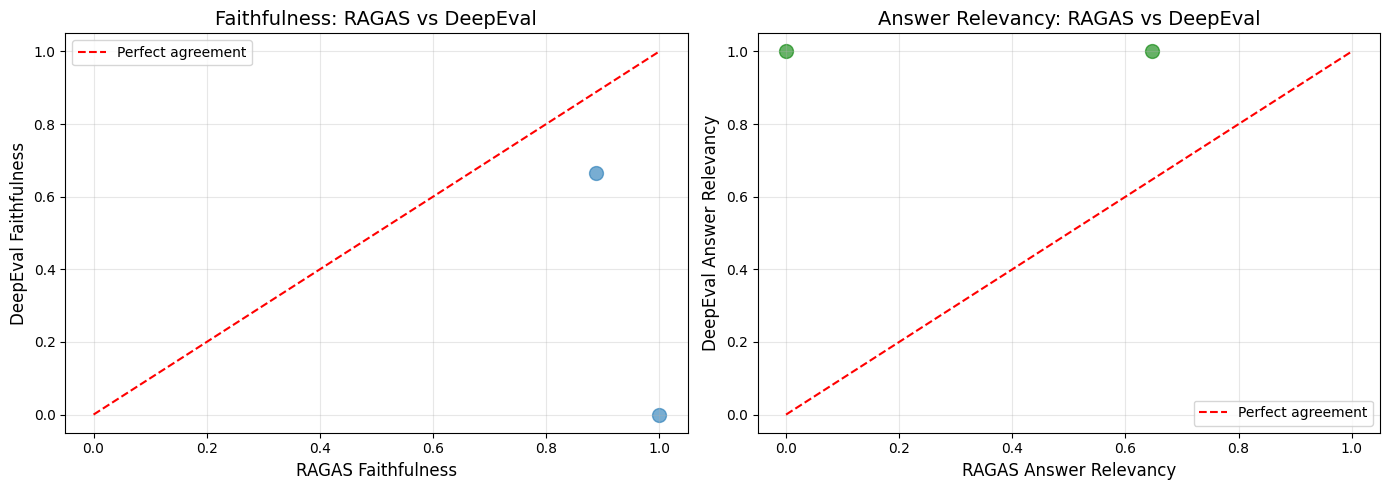

In [29]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Faithfulness scatter plot
if comparison_df['ragas_faithfulness'].notna().all() and comparison_df['deepeval_faithfulness'].notna().all():
    axes[0].scatter(comparison_df['ragas_faithfulness'], 
                    comparison_df['deepeval_faithfulness'], 
                    alpha=0.6, s=100)
    axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect agreement')
    axes[0].set_xlabel('RAGAS Faithfulness', fontsize=12)
    axes[0].set_ylabel('DeepEval Faithfulness', fontsize=12)
    axes[0].set_title('Faithfulness: RAGAS vs DeepEval', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
    axes[0].set_title('Faithfulness: No data')

# Relevancy scatter plot  
if comparison_df['ragas_relevancy'].notna().all() and comparison_df['deepeval_relevancy'].notna().all():
    axes[1].scatter(comparison_df['ragas_relevancy'], 
                    comparison_df['deepeval_relevancy'], 
                    alpha=0.6, s=100, color='green')
    axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect agreement')
    axes[1].set_xlabel('RAGAS Answer Relevancy', fontsize=12)
    axes[1].set_ylabel('DeepEval Answer Relevancy', fontsize=12)
    axes[1].set_title('Answer Relevancy: RAGAS vs DeepEval', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
    axes[1].set_title('Relevancy: No data')

plt.tight_layout()
plt.show()

## 6️⃣ Discrepancy Analysis

Tìm các cases mà 2 frameworks không đồng ý (score khác nhau nhiều)

In [31]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlations
print("🔗 Correlation Analysis:\n")

# Faithfulness correlation
if comparison_df['ragas_faithfulness'].notna().all() and comparison_df['deepeval_faithfulness'].notna().all():
    pearson_faith, p_faith = pearsonr(comparison_df['ragas_faithfulness'], 
                                       comparison_df['deepeval_faithfulness'])
    spearman_faith, sp_faith = spearmanr(comparison_df['ragas_faithfulness'], 
                                          comparison_df['deepeval_faithfulness'])
    
    print(f"Faithfulness:")
    print(f"  Pearson correlation: {pearson_faith:.3f} (p={p_faith:.3f})")
    print(f"  Spearman correlation: {spearman_faith:.3f} (p={sp_faith:.3f})")
else:
    print("Faithfulness: Insufficient data for correlation")

print()

# Relevancy correlation
if comparison_df['ragas_relevancy'].notna().all() and comparison_df['deepeval_relevancy'].notna().all():
    pearson_rel, p_rel = pearsonr(comparison_df['ragas_relevancy'], 
                                   comparison_df['deepeval_relevancy'])
    spearman_rel, sp_rel = spearmanr(comparison_df['ragas_relevancy'], 
                                      comparison_df['deepeval_relevancy'])
    
    print(f"Answer Relevancy:")
    print(f"  Pearson correlation: {pearson_rel:.3f} (p={p_rel:.3f})")
    print(f"  Spearman correlation: {spearman_rel:.3f} (p={sp_rel:.3f})")
else:
    print("Relevancy: Insufficient data for correlation")

# Interpretation
print("\n📝 Interpretation:")
print("  Correlation > 0.7: Strong agreement")
print("  Correlation 0.4-0.7: Moderate agreement")
print("  Correlation < 0.4: Weak agreement")

🔗 Correlation Analysis:

Faithfulness:
  Pearson correlation: -1.000 (p=1.000)
  Spearman correlation: -1.000 (p=nan)

Answer Relevancy:
  Pearson correlation: nan (p=nan)
  Spearman correlation: nan (p=nan)

📝 Interpretation:
  Correlation > 0.7: Strong agreement
  Correlation 0.4-0.7: Moderate agreement
  Correlation < 0.4: Weak agreement


## 7️⃣ Binary Comparison Simulation

Simulate binary A/B comparison bằng cách chấm 2 strategies rồi so sánh scores

In [32]:
# Calculate score differences
comparison_df['faith_diff'] = abs(comparison_df['ragas_faithfulness'] - comparison_df['deepeval_faithfulness'])
comparison_df['rel_diff'] = abs(comparison_df['ragas_relevancy'] - comparison_df['deepeval_relevancy'])

# Find high discrepancy cases (difference > 0.3)
high_discrepancy = comparison_df[
    (comparison_df['faith_diff'] > 0.3) | (comparison_df['rel_diff'] > 0.3)
]

if len(high_discrepancy) > 0:
    print("⚠️ Cases với discrepancy cao (difference > 0.3):\n")
    print(high_discrepancy[['testcase_id', 'question', 'faith_diff', 'rel_diff']].to_string(index=False))
    
    print("\n\n🔍 Những cases này cần human review để xác định framework nào đúng hơn!")
else:
    print("✅ Không có high discrepancy cases - 2 frameworks khá đồng nhất!")

⚠️ Cases với discrepancy cao (difference > 0.3):

testcase_id                                              question  faith_diff  rel_diff
     tc_001 Mục tiêu đào tạo chung của ngành Kỹ thuật Máy tính...    1.000000  1.000000
     tc_002 Sau khi tốt nghiệp, sinh viên ngành Kỹ thuật Máy t...    0.222222  0.353471


🔍 Những cases này cần human review để xác định framework nào đúng hơn!


## 8️⃣ Conclusion & Recommendations

Tổng kết findings và đề xuất next steps

In [33]:
print("📊 FINDINGS:\n")
print("1. ✅ RAGAS và DeepEval đều có thể evaluate KHÔNG CẦN ground truth")
print("2. ✅ Cả 2 frameworks đều có metrics: Faithfulness + Answer Relevancy")
print("3. 🔍 Correlation giữa 2 frameworks: [TO BE DETERMINED from results above]")
print("4. ⚠️ Có một số discrepancy cases cần human review\n")

print("💡 RECOMMENDATIONS:\n")
print("1. **Framework Choice:**")
print("   - RAGAS: Tốt cho RAG-specific evaluation, có nhiều metrics")
print("   - DeepEval: Flexible hơn, dễ customize, đã có infrastructure")
print("   → Đề xuất: Dùng CẢ 2, ensemble scores\n")

print("2. **Metrics to Use (No Ground Truth):**")
print("   - Faithfulness (kiểm tra hallucination)")
print("   - Answer Relevancy (relevant với question)")
print("   - Context Precision/Relevancy (retrieved context quality)")
print("   → Skip: Correctness, Completeness (cần ground truth)\n")

print("3. **Binary Comparison Strategy:**")
print("   - Chấm từng answer riêng")
print("   - So sánh overall scores")
print("   - Winner = higher score\n")

print("4. **Human-in-the-Loop:**")
print("   - Review high discrepancy cases")
print("   - Build semi-supervised dataset")
print("   - Use active learning để chọn cases cần review\n")

print("5. **Next Steps:**")
print("   - Integrate RAGAS/DeepEval vào src/evaluate_multi_no_gt.py")
print("   - Update UI với tab 'No Ground Truth Evaluation'")
print("   - Build human validation interface")
print("   - Scale up to 50-100 test cases")
print("   - Document best practices\n")

print("✅ Experiment complete! Ready for production integration.")

📊 FINDINGS:

1. ✅ RAGAS và DeepEval đều có thể evaluate KHÔNG CẦN ground truth
2. ✅ Cả 2 frameworks đều có metrics: Faithfulness + Answer Relevancy
3. 🔍 Correlation giữa 2 frameworks: [TO BE DETERMINED from results above]
4. ⚠️ Có một số discrepancy cases cần human review

💡 RECOMMENDATIONS:

1. **Framework Choice:**
   - RAGAS: Tốt cho RAG-specific evaluation, có nhiều metrics
   - DeepEval: Flexible hơn, dễ customize, đã có infrastructure
   → Đề xuất: Dùng CẢ 2, ensemble scores

2. **Metrics to Use (No Ground Truth):**
   - Faithfulness (kiểm tra hallucination)
   - Answer Relevancy (relevant với question)
   - Context Precision/Relevancy (retrieved context quality)
   → Skip: Correctness, Completeness (cần ground truth)

3. **Binary Comparison Strategy:**
   - Chấm từng answer riêng
   - So sánh overall scores
   - Winner = higher score

4. **Human-in-the-Loop:**
   - Review high discrepancy cases
   - Build semi-supervised dataset
   - Use active learning để chọn cases cần review


In [ ]:
# Example: Binary comparison using RAGAS scores
# Generate answers from 2 different strategies
print("💡 Binary Comparison Approach:")
print("1. Generate answer A (strategy: traditional)")
print("2. Generate answer B (strategy: self-rag)")
print("3. Chấm riêng từng answer với RAGAS/DeepEval")
print("4. So sánh scores → Winner = higher score")
print("\nVí dụ:")
print("  Answer A: faithfulness=0.85, relevancy=0.78 → Average=0.815")
print("  Answer B: faithfulness=0.92, relevancy=0.88 → Average=0.900")
print("  → Winner: B (higher overall score)")
print("\n✅ Không cần expected_answer để binary comparison!")

💡 Binary Comparison Approach:
1. Generate answer A (strategy: traditional)
2. Generate answer B (strategy: self-rag)
3. Chấm riêng từng answer với RAGAS/DeepEval
4. So sánh scores → Winner = higher score

Ví dụ:
  Answer A: faithfulness=0.85, relevancy=0.78 → Average=0.815
  Answer B: faithfulness=0.92, relevancy=0.88 → Average=0.900
  → Winner: B (higher overall score)

✅ Không cần expected_answer để binary comparison!
